# DEZEMBER

In this notebook, the preprocessed VACC corpus is annotated for the DEZEMBER alternation, i.e., all alternating instances of "dezember" and "zwölf" are tagged in the data. Subsequently, a dataset is prepared for modelling, i.e., all relevant variables (e.g., which variant was used in the previous slot?) from the tagged choice contexts are extracted or calculated. Further, the annotated instances are cross-tabulated and visualised in a switch rate plot.

As mentioned, the actual data used in the doctoral thesis needs to be requested from Ingo Siegert and subsequently preprocessed using the "VACC" notebook in the corresponding folder.

However, the dummy dataset provided for the "VACC" notebook generates a dataset that can be used to execute this very notebook. 

Refer to the relevant chapter in the doctoral thesis for further explanation of the steps below. 

In [1]:
#importing relevant modules
import pandas as pd, sys, os, shutil

#informing Python about a custom code directory and importing some of the modules from there
sys.path.append("../../Code/")
import annotation, quantification, persistence

In [2]:
#defining name of the alternation set and establishing its variants
alternating = "alternating_dez_zwoelf"
alternation_set = ["dezember", "zwölf"]

## Annotation

Annotation is typically done in multiple sessions. Hence, after each instance that you have annotated you may decide to end the session in which case everything tagged so far is saved. When starting the next session, you will only be assigned the remaining instances, i.e., those that have not been annotated thus far.

### Preparations

In [3]:
#copying the preprocessed corpus file into the folder "Quantitative_Analysis"
source_file = "../../VACC/3_Persistence_tagged/Persistence_VACC_all.csv"
destination_directory = ".."

destination_file = os.path.join(destination_directory, "VACC.csv")

if not os.path.exists(destination_file):
    shutil.copy2(source_file, destination_file)
    print("File moved.")
else:
    print("File already exists.")

File already exists.


In [4]:
#reading in the (copied) corpus file
df = pd.read_csv("../VACC.csv", sep=",", index_col=0)

#lower-casing the lemma column, as the code below only checks for lower-case variants
df.lemma = df.lemma.str.lower()

#creating a column for saving annotation decisions, if it does not already exist
if not alternating in df.columns:
    df[alternating] = pd.NA

#informing about how many alternating instances have already been tagged
print(f"Cases annotated as alternating: {len(df[df[alternating]=='yes'])}")

Cases annotated as alternating: 16


### Annotation tool

In short, the tool below 
- informs you about the annotation scheme
- tells you how many untagged instances you have got left
- provides you with the next case to annotate, i.e., a potentially alternating lemma including its immediate context
- displays an input field for deciding the current case according to the scheme
- prompts you to confirm your decision and/or gives you the option to end the current session
- searches for identical contexts prompting you whether the decision should be applied there as well

Decisions are saved in `df_updated`. After each session, this DataFrame still needs to be saved externally. To start a new session, start by reading in the current version of "../VACC.csv" under "Preparations" above.

In [5]:
#annotating
df_updated = annotation.alternation_check(df, alternation_set, alternating)

,word,speaker,interaction_id,alternating_dez_zwoelf
97,Peter,A,1,nan
98,ist,A,1,nan
99,eingetragen,A,1,nan
100,Hallo,S,2,nan
101,wie,S,2,nan
102,sieht,S,2,nan
103,mein,S,2,nan
104,Kalender,S,2,nan
105,am,S,2,nan
106,zwölften,S,2,no


 y


In [6]:
#saving the updated DataFrame externally, overwriting the empty or part-annotated file
df_updated.to_csv("../VACC.csv")

In [7]:
#once all potentially alternating cases have been annotated, all other tokens of the DataFrame are additionally tagged as non-alternating
if df_updated.loc[df_updated.lemma.isin(alternation_set), alternating].notna().all():
    df_updated[alternating].fillna(value="no", inplace=True)
    df_updated.to_csv("../VACC.csv")
    print("Annotation is completed.")
else:
    print("Annotation is not yet completed, rerun the tool above.")

Annotation is completed.


### Overview

See how many times each speaker used one of the alternating variants.

In [8]:
#reading in the annotated corpus, filtering, grouping and counting values
df = pd.read_csv("../VACC.csv", sep=",", index_col=0, na_filter=False)
df[df.alternating_dez_zwoelf=="yes"].groupby("speaker").lemma.value_counts()

speaker  lemma   
A        dezember    48
S        dezember    48
         zwölf       31
Name: lemma, dtype: int64

## Preparing DataFrame for modeling

In [3]:
#reading in the annotated corpus now including a column indicating where there was an opportunity ("yes") to choose a variant from the alternation set or not ("no")
df = pd.read_csv("../VACC.csv", index_col=0, na_filter=False, sep=",")

Below, the module `quantification` extracts or calculates all relevant variables for each choice contexts.

In the model for this alternation set, a variable for quasi-persistence on the part of the voice assistant was included. Before running `quantification`, information on instances of quasi-persistence need to be extracted from the relevant files and added to `df`.

In [4]:
#adding information on lexical quasi-persistence to df, by reading in the combined file...
df_quasi_p = pd.read_csv("../../VACC/3_Persistence_tagged/Quasi_persistence_VACC_all.csv", na_filter=False, sep=",")
#... and summarising all kinds of lexical quasi-persistence, i.e., writing True in new column, if any lexical SPP was produced by the voice assistant
df["quasi_persistence"] = df_quasi_p[["persistence_unigrams_lemma", "persistence_bigrams_lemma", "persistence_trigrams_lemma", "persistence_quadrigrams_lemma"]].applymap(lambda x: str(x).startswith("SPP")).any(axis=1)

In [5]:
#creating variation_sample, i.e., only annotated choice contexts along with relevant variabkles
variation_sample = quantification.prepare_data_for_modeling(df, alternating, restrict="yes", beta_variants=["zwölf", "dezember"])

In [7]:
variation_sample.CURRENT.value_counts(normalize=True)

dezember    0.75
zwölf       0.25
Name: CURRENT, dtype: float64

## Cross-tabulation

In [8]:
contingency_table = pd.crosstab(variation_sample.PREVIOUS, variation_sample.CURRENT)
contingency_table["Total in PREVIOUS"] = contingency_table.sum(axis=1)
contingency_table.loc["Total in CURRENT"] = contingency_table.sum(axis=0)
contingency_table

CURRENT,dezember,zwölf,Total in PREVIOUS
PREVIOUS,,,
dezember,16,8,24
zwölf,8,0,8
Total in CURRENT,24,8,32


## Calculating switch rates as a function of variant proportions

In [10]:
df = pd.read_csv("../VACC.csv", na_filter=False, sep=",")

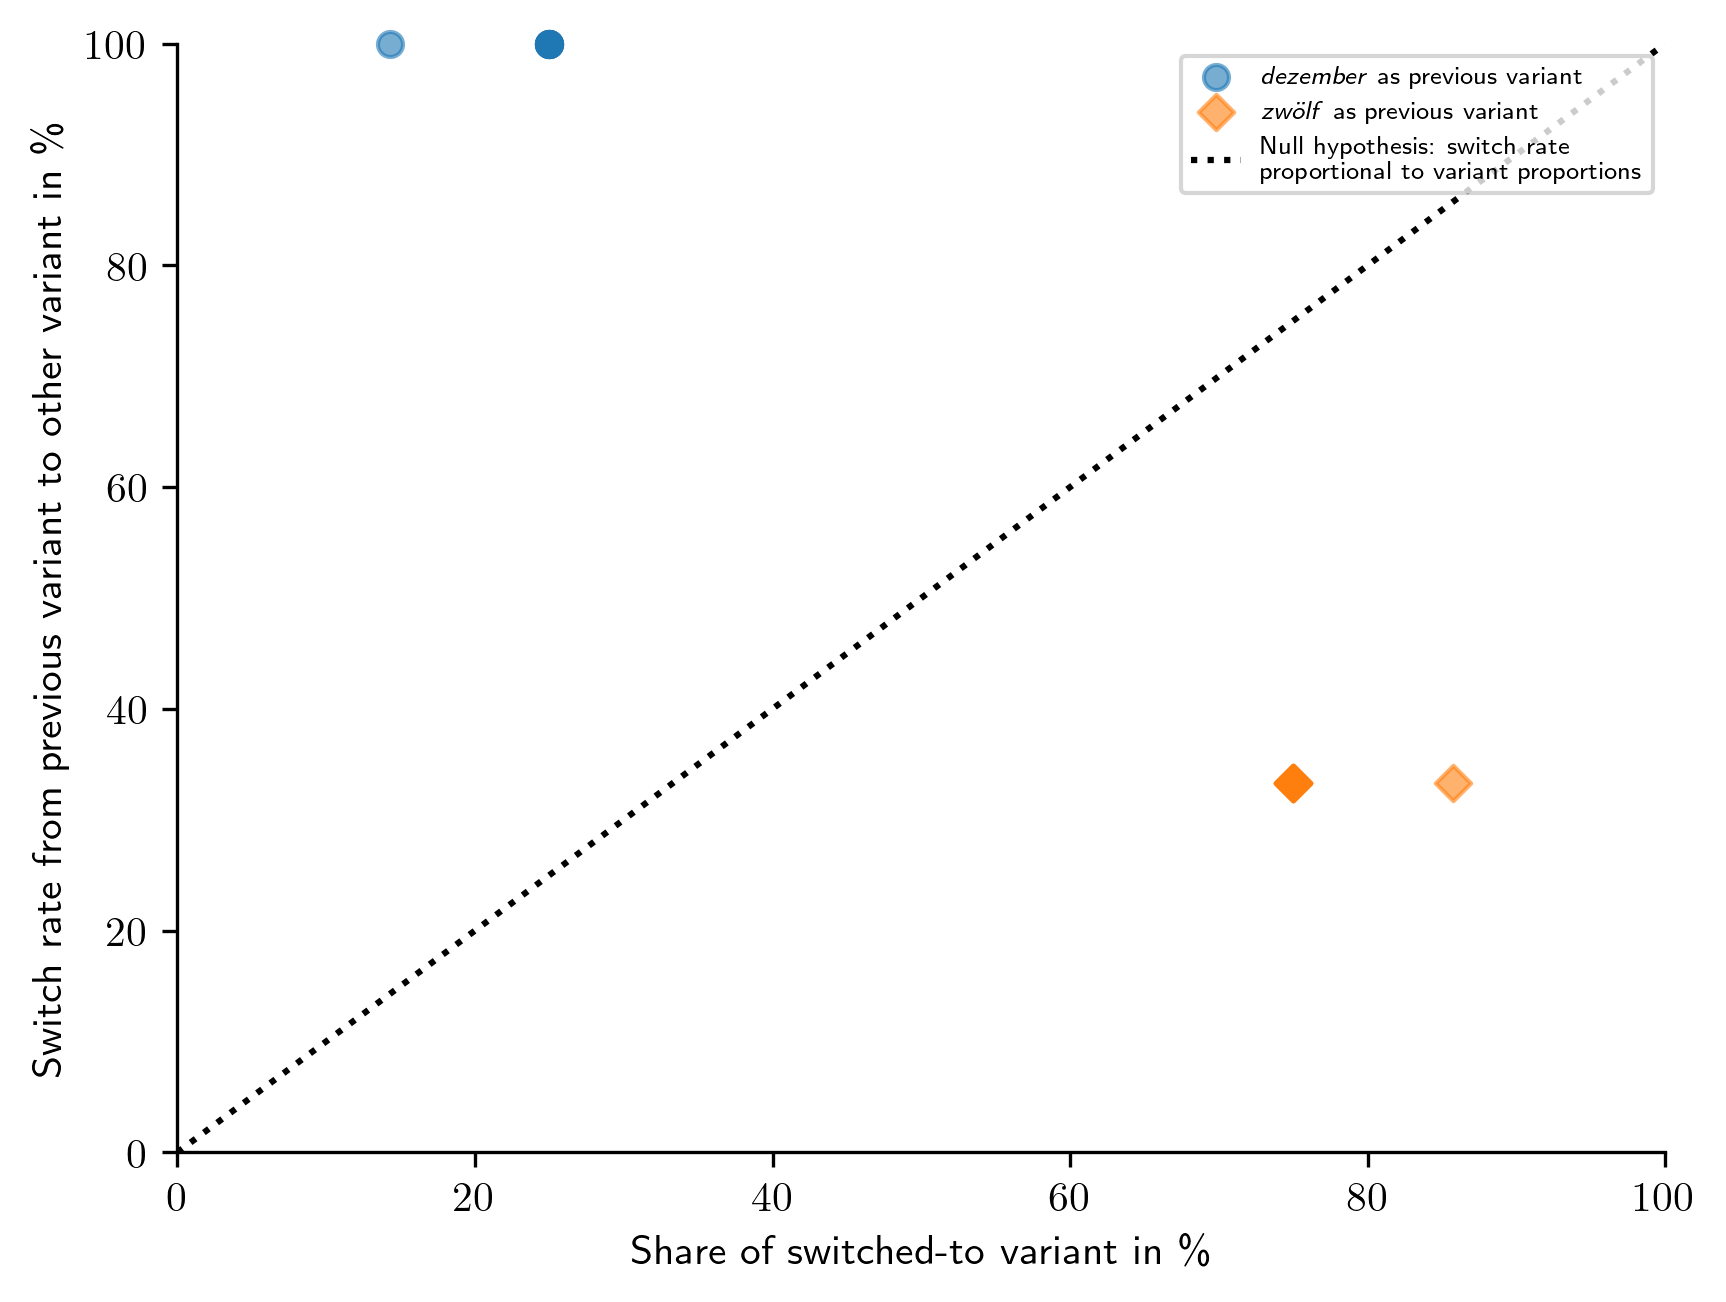

In [11]:
path = "switch_rate_plot_DEZEMBER.png"
#considering switch/persistence from the very last use of any variant, irrespective of who uttered it, to the current variant
quantification.plot_switch_rate_over_variant_proportions(df, variation_sample, alternation_set, alternating, save_to=path, DEZEMBER=True)